# Q-Flow:

In [19]:
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from scipy.interpolate import RectBivariateSpline, RegularGridInterpolator
from scipy.special import factorial, gammaln
import matplotlib.pyplot as plt

from sklearn.neighbors import KernelDensity

import qutip as qt

from copy import deepcopy

In [ ]:
import torch
import torch.nn as nn

class AffineCoupling(nn.Module):

    def __init__(self, mask: torch.Tensor, hidden_dim: int):

        super().__init__()
        self.register_buffer("mask", mask.float())
        self.input_dim = mask.numel()
        self.hidden_dim = hidden_dim

        # Networks take the masked input (zeros where mask==0).
        # Output has same dimension as input so we can multiply by (1-mask).
        self.scale_network = nn.Sequential(
            nn.Linear(self.input_dim, hidden_dim),
            nn.ReLU(),
            nn.Linear(hidden_dim, hidden_dim),
            nn.ReLU(),
            nn.Linear(hidden_dim, self.input_dim),
            nn.Tanh()  # bounds s; multiply by small factor if desired
        )

        self.trans_network = nn.Sequential(
            nn.Linear(self.input_dim, hidden_dim),
            nn.ReLU(),
            nn.Linear(hidden_dim, hidden_dim),
            nn.ReLU(),
            nn.Linear(hidden_dim, self.input_dim)
        )

        nn.init.zeros_(self.scale_network[-2].weight) if hasattr(self.scale_network[-2], "weight") else None
        nn.init.zeros_(self.trans_network[-1].weight)
        nn.init.zeros_(self.trans_network[-1].bias)

    def forward(self, x: torch.Tensor):

        masked = x * self.mask
        s = self.scale_network(masked) * (1.0 - self.mask)
        t = self.trans_network(masked) * (1.0 - self.mask)

        y = masked + (1.0 - self.mask) * (x * torch.exp(s) + t)
        log_det = torch.sum(s, dim=1)

        return y, log_det

    def inverse(self, y: torch.Tensor):

        masked = y * self.mask
        s = self.scale_network(masked) * (1.0 - self.mask)
        t = self.trans_network(masked) * (1.0 - self.mask)

        x = masked + (1.0 - self.mask) * ((y - t) * torch.exp(-s))
        log_det = -torch.sum(s, dim=1)

        return x, log_det


In [21]:
class Flow(nn.Module):

    def __init__(self, masks, hidden_dim: int):
        super().__init__()

        masks_tensors = [
            (m if isinstance(m, torch.Tensor) else torch.tensor(m, dtype=torch.float32))
            for m in masks
        ]

        self.layers = nn.ModuleList([AffineCoupling(m, hidden_dim) for m in masks_tensors])

    def forward(self, x: torch.Tensor):

        y = x
        log_det_tot = x.new_zeros(x.size(0))
        
        for layer in self.layers:
            y, ld = layer(y)
            log_det_tot = log_det_tot + ld

        return y, log_det_tot

    def inverse(self, y: torch.Tensor):

        x = y
        log_det_tot = y.new_zeros(y.size(0))
        # invert in reverse order
        for layer in reversed(self.layers):
            x, ld = layer.inverse(x)
            log_det_tot = log_det_tot + ld

        return x, log_det_tot

# Initial Q-funciton

/home/johann/miniconda3/envs/new_base/lib/python3.13/site-packages/qutip/solver/solver_base.py:576: FutureWarning: e_ops will be keyword only from qutip 5.3 for all solver
  warnings.warn(


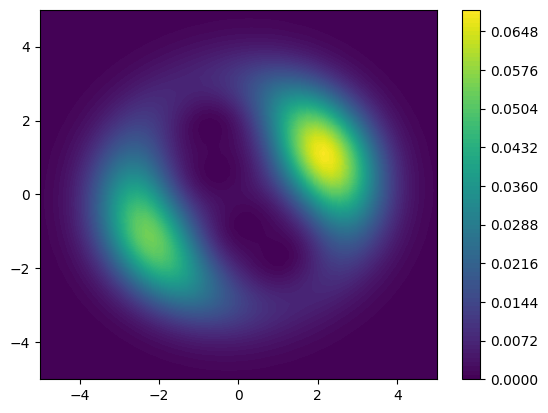

In [ ]:
# Hilbert space cutoff
N = 5  # dimension (Fock cutoff, increased to capture coherent state better!)

# annihilation operator
a = qt.destroy(N)

# frequency of oscillator
omega = 2.0
H = omega * a.dag() * a

# damping parameters
gamma = 2.0   # damping rate
nbar = 0.0    # thermal occupation number

c_ops = []
c_ops.append(np.sqrt(gamma * (nbar+1)) * a)      # decay
c_ops.append(np.sqrt(gamma * nbar) * a.dag())    # thermal excitation

# initial state: coherent state
alpha0 = 2.0 + 1.0j
rho0 = qt.coherent_dm(N, alpha0)

tlist = np.arange(0, 2, 0.5) 
# evolve master equation
result = qt.mesolve(H, rho0, tlist, c_ops, [])

# define grid in phase space
xvec = np.linspace(-5, 5, 50)   # q axis
yvec = np.linspace(-5, 5, 50)   # p axis

# precompute Q functions for all time steps
Q_init = qt.qfunc(result.states[0], xvec, yvec)

plt.contourf(xvec, yvec, Q_init, 100, cmap="viridis")
plt.colorbar()
plt.show()

In [16]:
Q_init.shape

(50, 50)

# Utility Functions

In [ ]:
interpulate_Q = RectBivariateSpline(xvec, yvec, Q_init)
interp_Q = RegularGridInterpolator((yvec, xvec), Q_init, bounds_error=False, fill_value=1e-12)

def ensure_possitive_Q(x,y):
    return max(interpulate_Q(y,x)[0,0], 0.0)


def metropolis_hasting(N=5000, x0=0.0, sigma=0.5, y0=0.0, burn=5000, b=7, acc=True):

    samples = []
    acc_rate = 0.0
    u = np.random.uniform(0, 1, N + burn)

    X = [x0,y0]
    q_current = interp_Q([[y0,x0]])#ensure_possitive_Q(x0, y0)

    for i in range(N + burn):

        X_prop = X + np.random.normal(0,sigma,2)

        q_prop = interp_Q([[X_prop[1], X_prop[0]]])#ensure_possitive_Q(X_prop[0], X_prop[1])

        if u[i] <= q_prop/q_current and i >= burn and (-b <= X_prop[0] <= b ) and (-b <= X_prop[1] <= b):

            q_current = q_prop
            X = X_prop
            acc_rate += 1
        
        if i >= burn:
            samples.append(X)

    if (acc == True):
        print("Acceptance Rate of MH: ", np.round(acc_rate/(N+burn),4))


    return np.array(samples, dtype=np.float32)


def sample_from_flow(flow, n_samples):
    device = next(flow.parameters()).device
    # get how many dimensions the flow is (2)
    latent_dim = flow.layers[0].input_dim   
    z = torch.randn(n_samples, latent_dim, device=device)
    x_sample, x_log_det_sample = flow.forward(z)
    return x_sample, x_log_det_sample


def L_operator(Q, xvec, yvec, gamma, nbar, omega, dx, dy):
    # compute partial derivatives with finite differences
    dQ_dq = np.gradient(Q, dx, axis=0)   
    dQ_dp = np.gradient(Q, dy, axis=1)    
    d2Q_dq2 = np.gradient(dQ_dq, dx, axis=0)  
    d2Q_dp2 = np.gradient(dQ_dp, dy, axis=1)  
    
    q = xvec[:, None]  # 2D grid of q
    p = yvec[None, :]  # 2D grid of p

    term_diffusion = 0.25 * gamma * (nbar + 1) * (d2Q_dq2 + d2Q_dp2)
    term_drift_q = (0.5*gamma*q - omega*p) * dQ_dq
    term_drift_p = (0.5*gamma*p + omega*q) * dQ_dp
    term_const = gamma * Q  # from the +gamma_j Q term

    # print("diffusion, drift_q, drift_p, const =",
    #     np.sum(term_diffusion)*dx*dy,
    #     np.sum(term_drift_q)*dx*dy,
    #     np.sum(term_drift_p)*dx*dy,
    #     np.sum(term_const)*dx*dy)
    print("∫ diffusion",np.sum(term_diffusion)*dx*dy)
    
    return term_const + term_diffusion + term_drift_q + term_drift_p

def test_L_gaussian_convergence(xvec, yvec, gamma, nbar, omega, a=0.8):
    for factor in [1, 0.5, 0.25]:
        # build grid
        Nx = int(len(xvec) * factor)
        Ny = int(len(yvec) * factor)
        xv = np.linspace(xvec[0], xvec[-1], Nx)
        yv = np.linspace(yvec[0], yvec[-1], Ny)
        dx = xv[1]-xv[0]; dy = yv[1]-yv[0]
        Q = np.exp(-a*(xv[:,None]**2 + yv[None,:]**2))
        Q /= (np.sum(Q)*dx*dy)
        LQ = L_operator(Q, xv, yv, gamma, nbar, omega, dx, dy)
        print("grid:", Nx, Ny, " ∫Q=", np.sum(Q)*dx*dy, " ∫LQ=", np.sum(LQ)*dx*dy,
              " max|LQ|=", np.max(np.abs(LQ)))



# Train Flow Model

In [34]:

def train_init_flow(sample, mask=None, hidden_dim=128, epochs=1000, lr=5e-4):

    if mask == None:
        mask = [[1.0, 0.0],
                [0.0, 1.0],
                [1.0, 0.0],         
                [0.0, 1.0],
                [1.0, 0.0],         
                [0.0, 1.0],
                [1.0, 0.0],
                [0.0, 1.0],
]

    init_flow = Flow(mask, hidden_dim)
    if torch.cuda.device_count():
        init_flow = init_flow.cuda()

    device = next(init_flow.parameters()).device
    print(device)

    sample = metropolis_hasting(5_000, x0=np.random.uniform(-1,1), y0=np.random.uniform(-1,1))

    sample = torch.tensor(sample, dtype=torch.float32, device=device)

    # optimizer
    optimizer = optim.Adam(init_flow.parameters(), lr=lr)

    loss_log = []

    # training loop
    for epoch in range(epochs):

        optimizer.zero_grad()

        z, logdet = init_flow.inverse(sample)

        # use gaussian prior
        # the log probability of observing z
        log_pz = -0.5 * torch.sum(z**2, dim=1) - 0.5 * z.size(1) * torch.log(torch.tensor(2*torch.pi, device=device))

        log_q = log_pz + logdet

        loss = -torch.mean(log_q)

        loss.backward()
        optimizer.step()

        if epoch % 20 == 0:
            print(f"Epoch {epoch}: loss = {loss.item():.4f}")

        loss_log.append(loss.item())

        sample = metropolis_hasting(5_000, x0=np.random.uniform(-1,1), y0=np.random.uniform(-1,1), acc=False)

        sample = torch.tensor(sample, dtype=torch.float32, device=device)



    return init_flow, loss_log

# sample from flow and compare that to the true Q_init values, to minimize
def refining_init_flow(flow, epochs=1000, lr=5e-4, b=5, eps=1e-12):
    
    if torch.cuda.device_count():
        flow = flow.cuda()
    device = next(flow.parameters()).device
    print(device)

    interp = RegularGridInterpolator((yvec, xvec), Q_init, bounds_error=False, fill_value=eps)

    # optimizer
    optimizer = optim.Adam(flow.parameters(), lr=lr)

    loss_log = []
    kld_log = []
    ess_log = []

    # training loop
    for epoch in range(epochs):

        optimizer.zero_grad()

        # sample from Q_theta and get log(Q_theta)
        with torch.no_grad():
            init_flow_sample, _ = sample_from_flow(flow, 20_000)

        # remove all data-points into the same area as Q_init
        x_np = init_flow_sample.detach().cpu().numpy()
        frac_out = np.mean((np.abs(x_np) > b).any(axis=1))
        init_flow_sample = torch.clamp(init_flow_sample, -b, b)

        # compute log_q_theta(x)
        z, logdet = flow.inverse(init_flow_sample)
        log_pz = -0.5 * torch.sum(z**2, dim=1) - 0.5 * z.size(1) * torch.log(torch.tensor(2*torch.pi, device=device))
        log_q_theta = log_pz + logdet

        # get q_init coordinate samples
        q_init_sample = init_flow_sample.detach().cpu().numpy()

        # convert to grid coordinates to sample from Q_init
        coords = np.stack([q_init_sample[:,1], q_init_sample[:,0]],axis=1)
        coords_values = interp(coords)
        coords_values = np.maximum(coords_values, eps)

        log_q_init = torch.as_tensor(np.log(coords_values),dtype=torch.float32, device=device)     

        l = log_q_init - log_q_theta.detach() # LSE stability method
        l = l - torch.max(l)
        w = torch.exp(l)
        
        # compute ESS diagnostic (numpy for safety)
        w_np = w.detach().cpu().numpy()
        w_sum = w_np.sum()
        w2_sum = (w_np**2).sum()
        ess = (w_sum**2) / (w2_sum + 1e-12)
        ess_frac = ess / float(len(w_np))


        w = w / (w.sum() + 1e-12) # ensure that mean(w) = 1
        w = w.detach() # treats weights as constant wrt theta, avoid second gradient term

        loss = -torch.mean(w * log_q_theta)

        kld = torch.sum(w * (log_q_init - log_q_theta)).item()

        loss.backward()
        optimizer.step()

        if epoch % 150 == 0:
            print(f"Epoch {epoch}: loss={loss.item():.6f}, frac_out={frac_out:.3f}")
            print(f"ESS_frac: {ess_frac:.4f}, KL-Divergnece {kld:.6f}") 

        loss_log.append(loss.item())
        kld_log.append(kld)
        ess_log.append(ess_frac)


    return flow, loss_log, kld_log, ess_log


## Main Loop

Normalization:  0.9990956207764563
Acceptance Rate of MH:  0.7317


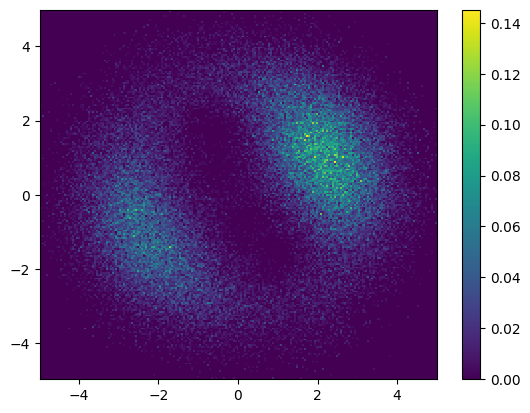

cuda:0
Acceptance Rate of MH:  0.3885
Epoch 0: loss = 6.3719
Epoch 20: loss = 4.1037
Epoch 40: loss = 3.8775
Epoch 60: loss = 3.9801
Epoch 80: loss = 3.9967
Epoch 100: loss = 3.9321
Epoch 120: loss = 3.9860
Epoch 140: loss = 3.8533
Epoch 160: loss = 3.7568
Epoch 180: loss = 3.9023


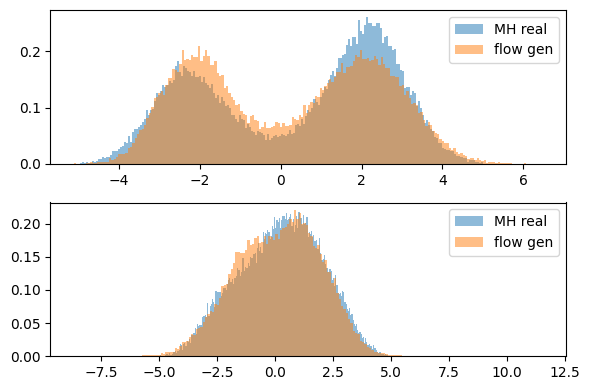

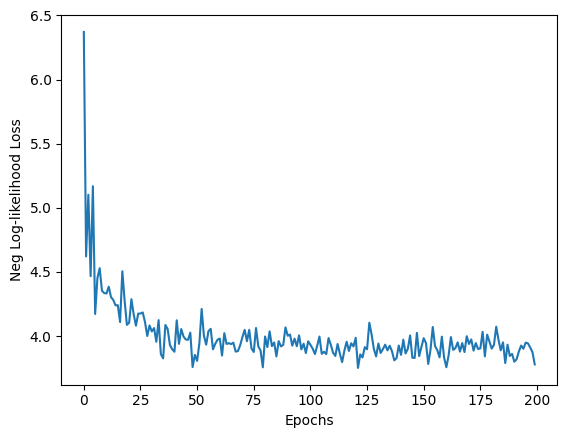

cuda:0
Epoch 0: loss=0.000196, frac_out=0.007
ESS_frac: 0.7813, KL-Divergnece 0.092173
Epoch 150: loss=0.000192, frac_out=0.005
ESS_frac: 0.9516, KL-Divergnece 0.024151
Epoch 300: loss=0.000191, frac_out=0.004
ESS_frac: 0.9712, KL-Divergnece 0.013286
Epoch 450: loss=0.000191, frac_out=0.003
ESS_frac: 0.9737, KL-Divergnece 0.012036
Epoch 600: loss=0.000191, frac_out=0.003
ESS_frac: 0.9822, KL-Divergnece 0.007371
Epoch 750: loss=0.000191, frac_out=0.002
ESS_frac: 0.9830, KL-Divergnece 0.008645
Epoch 900: loss=0.000192, frac_out=0.002
ESS_frac: 0.9784, KL-Divergnece 0.009627


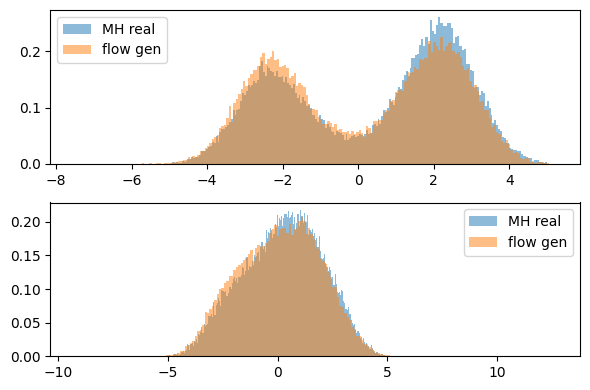

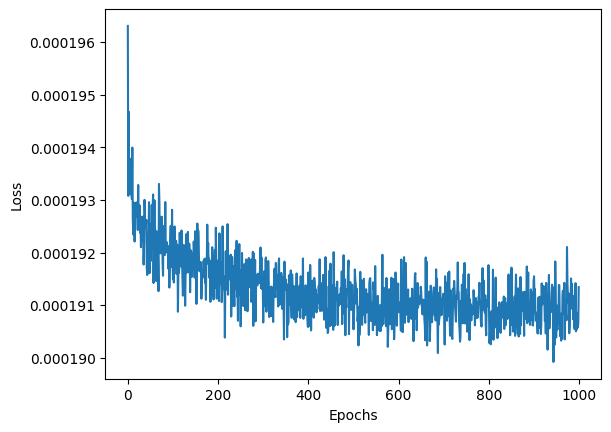

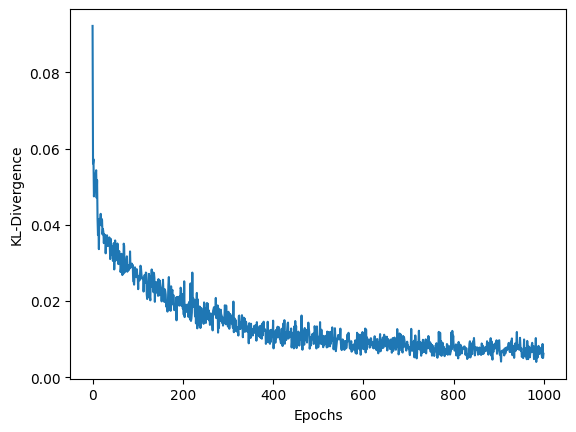

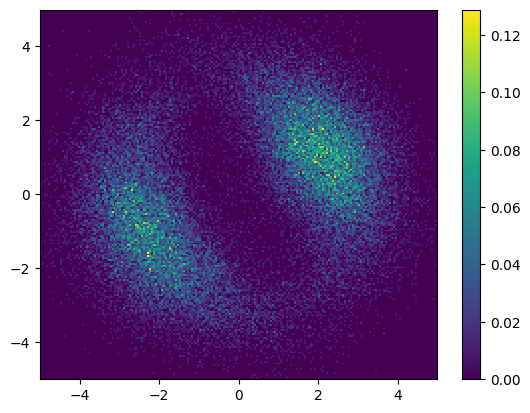

In [44]:
# initialise

# -----------------------------------------------------------------------------------------------
# checking normalization
# -----------------------------------------------------------------------------------------------
dx = xvec[1] - xvec[0]
dy = yvec[1] - yvec[0]
approx_norm = Q_init.sum() * dx * dy
print("Normalization: ", approx_norm)

# -----------------------------------------------------------------------------------------------
# step 1: get Q(theta) with M-H sampling from Q_init minimizing neg-log likelihood
# -----------------------------------------------------------------------------------------------
Q_init_samples = metropolis_hasting(N=100_000, sigma=0.5, b=7)
plt.hist2d(Q_init_samples[:,0], Q_init_samples[:,1], bins=200, density=True)
plt.colorbar()
plt.show()

loss1 = []

Flow_current, loss1 = train_init_flow(sample=Q_init_samples, epochs=200, lr=1e-2)

gen, _ = sample_from_flow(Flow_current, 50000)
gen = gen.detach().cpu().numpy()
real = np.asarray(Q_init_samples)

D = real.shape[1]
fig, axes = plt.subplots(min(D,4), 1, figsize=(6, 2*min(D,4)), squeeze=False)
for i in range(min(D,4)):
    ax = axes[i,0]
    ax.hist(real[:,i], bins=200, density=True, alpha=0.5, label='MH real')
    ax.hist(gen[:,i], bins=200, density=True, alpha=0.5, label='flow gen')
    ax.legend()
plt.tight_layout()
plt.show()

plt.plot(np.arange(0,len(loss1),1),loss1)
plt.xlabel('Epochs')
plt.ylabel('Neg Log-likelihood Loss')
plt.show()

# -----------------------------------------------------------------------------------------------
# step 2: minimize KL(Q_init || Q(theta))
# -----------------------------------------------------------------------------------------------

# now train the first Flow_current model {Q(theta)} to approximate Q_init
loss2 = []
kld = []

Flow_current, loss2, kld = refining_init_flow(flow=Flow_current, epochs=1000, lr=1e-3)

gen, _ = sample_from_flow(Flow_current, 50000)
gen = gen.detach().cpu().numpy()
real = np.asarray(Q_init_samples)

D = real.shape[1]
fig, axes = plt.subplots(min(D,4), 1, figsize=(6, 2*min(D,4)), squeeze=False)
for i in range(min(D,4)):
    ax = axes[i,0]
    ax.hist(real[:,i], bins=200, density=True, alpha=0.5, label='MH real')
    ax.hist(gen[:,i], bins=200, density=True, alpha=0.5, label='flow gen')
    ax.legend()
plt.tight_layout()
plt.show()


plt.plot(np.arange(0,len(loss2),1),loss2)
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.show()

plt.plot(np.arange(0,len(kld),1),kld)
plt.xlabel('Epochs')
plt.ylabel('KL-Divergence')
plt.show()

mask = (
    (gen[:, 0] >= xvec.min()) & (gen[:, 0] <= xvec.max()) &
    (gen[:, 1] >= yvec.min()) & (gen[:, 1] <= yvec.max())
)
gen_in = gen[mask]

plt.hist2d(gen_in[:,0], gen_in[:,1], bins=200, density=True)
plt.colorbar()
plt.show()

Mean absolute difference: 0.00026977811768437795
Total absolute difference: 0.6744452942109449


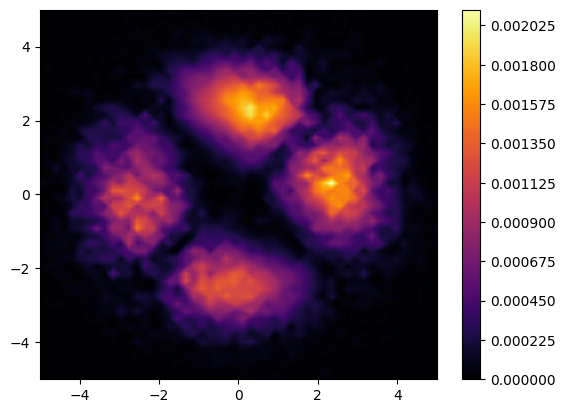

In [ ]:
# define same grid edges as the ground-truth Q function
x_edges = np.linspace(xvec.min(), xvec.max(), len(xvec)+1)
y_edges = np.linspace(yvec.min(), yvec.max(), len(yvec)+1)

# 2D histogram (normalized to integrate to 1)
H_gen, _, _ = np.histogram2d(gen[:, 0], gen[:, 1],
                             bins=[x_edges, y_edges],
                             density=True)

mask = (
    (gen[:, 0] >= xvec.min()) & (gen[:, 0] <= xvec.max()) &
    (gen[:, 1] >= yvec.min()) & (gen[:, 1] <= yvec.max())
)
gen_in = gen[mask]

# ensure both have same shape
Q_norm = Q_init / np.sum(Q_init)
H_norm = H_gen / np.sum(H_gen)

abs_diff = np.abs(Q_norm - H_norm)
mean_abs_diff = np.mean(abs_diff)
total_abs_error = np.sum(abs_diff)

print("Mean absolute difference:", mean_abs_diff)
print("Total absolute difference:", total_abs_error)

# visualize the difference
plt.contourf(xvec, yvec, abs_diff.T, 200, cmap='inferno')
plt.colorbar()
plt.show()



In [ ]:


# -----------------------------------------------------------------------------------------------
# loop over time
# -----------------------------------------------------------------------------------------------

T = 1.0
dt = 0.001
lr = 1e-3
epochs = 10
b = 5.0             # domain box for diagnostics only (don't clamp)
eps = 1e-12
N_total = 50_000
batch_size = 5000 

count = 0

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

dx = xvec[1] - xvec[0]
dy = yvec[1] - yvec[0]

print(dx, dy)

log2pi_const = 0.5 * 2 * np.log(2 * np.pi)

Q_t = Q_init.copy() 

flow = Flow_current
flow = flow.to(device)

for t in np.arange(0,T,dt):
    print('----------------------------------------------------------------')
    print("Current Time", t)
    print("----------------------------------------------------------------")

    Q_t = sample_from_flow(flow, N_total)

    LQ = L_operator(Q_t, xvec, yvec, gamma, nbar, omega, dx, dy)
    LQdt = LQ * dt
    Q_t = Q_t + LQdt 
    Q_t = Q_t / (np.sum(Q_t) * dx * dy + 1e-12)
    
    interp = RegularGridInterpolator((yvec, xvec), Q_t, bounds_error=False, fill_value=eps)
    
    # -------------------------------------------------------------------------------------

    # plt.contourf(xvec, yvec, Q_t)
    # plt.show()

    # # normalize Q_t
    # integral_LQ = np.sum(LQdt) * dx * dy
    # integral_Q = np.sum(Q_t) * dx * dy
    # print("∫ Q =", integral_Q, " ∫ LQ =", integral_LQ)

    # test_L_gaussian_convergence(xvec, yvec, gamma, nbar, omega, a=0.8)

    # dx = xvec[1]-xvec[0]; dy = yvec[1]-yvec[0]
    # LQ = L_operator(Q_t, xvec, yvec, gamma, nbar, omega, dx, dy)
    # total_LQ = np.sum(LQ) * dx * dy
    # print("∫ LQ =", total_LQ)

    # -------------------------------------------------------------------------------------

    Q_f = deepcopy(flow).to(device)
    optimizer = optim.Adam(Q_f.parameters(), lr=lr)

    z_dim = Q_f.layers[0].input_dim

    # epochs for each time step
    for epoch in range(epochs):
        # sample from Q_f
        optimizer.zero_grad()

        # sample from Q_theta and get log(Q_theta)
        with torch.no_grad():
            all_samples, _ = sample_from_flow(Q_f, N_total)

        # remove all data-points into the same area as Q_init
        x_np = all_samples.detach().cpu().numpy()
        frac_out = np.mean((np.abs(x_np) > b).any(axis=1))
        all_samples = torch.clamp(all_samples, -b, b)

        total_loss = 0.0
        total_weight_sum = 0.0

        for start in range(0, N_total, batch_size):

            batch = all_samples[start:start+batch_size]

            # compute log_q_f(x)
            z, logdet = Q_f.inverse(batch)
            log_pz = -0.5 * torch.sum(z**2, dim=1) - 0.5 * z.size(1) * torch.log(torch.tensor(2*torch.pi, device=device))
            log_q_f = log_pz + logdet        
            
            # convert to grid coordinates to sample
            # coords = batch.detach().cpu().numpy()
            # interp_coords = np.stack([coords[:,1], coords[:,0]],axis=1)
            # q_vales = interp(interp_coords)
            # q_vales = np.maximum(q_vales, eps)
            # log_q_t = torch.as_tensor(np.log(q_vales),dtype=torch.float32, device=device)
            z, logdet = Q_t.inverse(batch)
            log_pz = -0.5 * torch.sum(z**2, dim=1) - 0.5 * z.size(1) * torch.log(torch.tensor(2*torch.pi, device=device))
            log_q_t = log_pz + logdet  

            # minimize KL-divergence (Q_t || Q_f)
            l = log_q_t - log_q_f.detach() # LSE stability method
            l = l - torch.max(l)
            w = torch.exp(l)

            # baseline (b in paper)
            baseline = torch.mean(log_q_t - log_q_f.detach())
            
            # compute ESS diagnostic (numpy for safety)
            w_np = w.detach().cpu().numpy()
            w_sum = w_np.sum()
            w2_sum = (w_np**2).sum()
            ess = (w_sum**2) / (w2_sum + 1e-12)
            ess_frac = ess / float(len(w_np))

            w = w / (w.sum() + 1e-12) # ensure that mean(w) = 1
            w = w.detach() # treats weights as constant wrt theta, avoid second gradient term

            batch_loss = -torch.mean(w * log_q_f)
            batch_loss.backward()
            total_loss += batch_loss.item()
            total_weight_sum += torch.sum(w).item()

        optimizer.step()

        if epoch % 10 == 0:
            print(f"Epoch {epoch}: loss={total_loss:.6f}, frac_out={frac_out:.3f}, ESS_frac: {ess_frac:.4f}")


    # set flow = Q_f
    flow = Q_f

    if count % 33 == 0: 

        gen, _ = sample_from_flow(flow, 50000)
        gen = gen.detach().cpu().numpy()
        real = np.asarray(Q_init_samples)

        D = real.shape[1]
        fig, axes = plt.subplots(min(D,4), 1, figsize=(6, 2*min(D,4)), squeeze=False)
        for i in range(min(D,4)):
            ax = axes[i,0]
            ax.hist(real[:,i], bins=200, density=True, alpha=0.5, label='MH real')
            ax.hist(gen[:,i], bins=200, density=True, alpha=0.5, label='flow gen')
            ax.set_title(f"Marginal dim {i}")
            ax.legend()
        plt.tight_layout()
        plt.show()

        plt.hist2d(gen[:,0], gen[:,1],bins=[200,200],density=True)
        plt.colorbar()
        plt.show()

    count += 1


0.204081632653061 0.204081632653061
----------------------------------------------------------------
Current Time 0.0
----------------------------------------------------------------


TypeError: can't convert cuda:0 device type tensor to numpy. Use Tensor.cpu() to copy the tensor to host memory first.

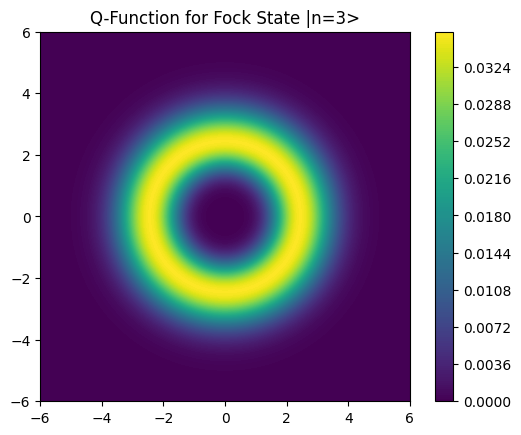

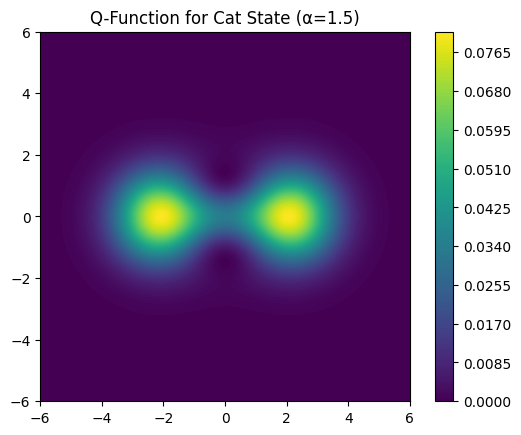

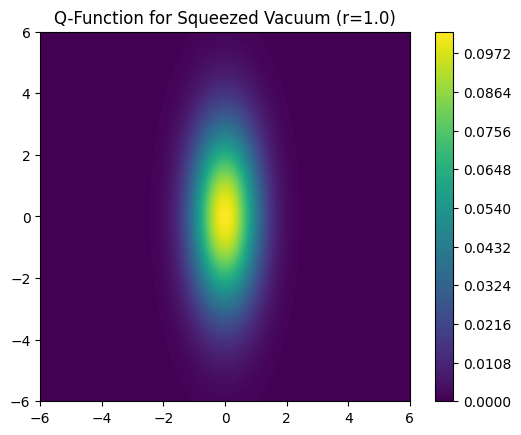

In [ ]:
import numpy as np
import qutip as qt
import matplotlib.pyplot as plt

def create_fock_state(n, N):
    psi = qt.fock(N, n)
    return qt.ket2dm(psi)

def create_cat_state(alpha, N):
    psi_plus = qt.coherent(N, alpha)
    psi_minus = qt.coherent(N, -alpha)
    
    psi = (psi_plus + psi_minus).unit()
    return qt.ket2dm(psi)

def create_squeezed_state(r, N):
    psi_vac = qt.fock(N, 0)
    squeeze_op = qt.squeeze(N, r) 
    
    psi = squeeze_op * psi_vac 
    return qt.ket2dm(psi.unit())


def plot_q_function(rho, xvec, yvec, title):
    """Calculates and plots the Q-function for a given state."""
    Q = qt.qfunc(rho, xvec, yvec)
    
    plt.figure()
    plt.contourf(xvec, yvec, Q, 200, cmap="viridis")
    plt.colorbar()
    plt.title(title)
    plt.gca().set_aspect('equal', adjustable='box')

# Hilbert space cutoff (MUST be large enough)
N = 25  

# phase space grid
xvec = np.linspace(-6, 6, 200)
yvec = np.linspace(-6, 6, 200)

n_fock = 3
rho_fock = create_fock_state(n=n_fock, N=N)
plot_q_function(rho_fock, xvec, yvec, f"Q-Function for Fock State |n={n_fock}>")

alpha_cat = 1.5 # 'size' of the cat
rho_cat = create_cat_state(alpha=alpha_cat, N=N)
plot_q_function(rho_cat, xvec, yvec, f"Q-Function for Cat State (α={alpha_cat})")

r_squeeze = 1.0  # squeezing parameter
rho_squeezed = create_squeezed_state(r=r_squeeze, N=N)
plot_q_function(rho_squeezed, xvec, yvec, f"Q-Function for Squeezed Vacuum (r={r_squeeze})")

plt.show()

Normalization:  0.999954247969129
Acceptance Rate of MH:  0.7302


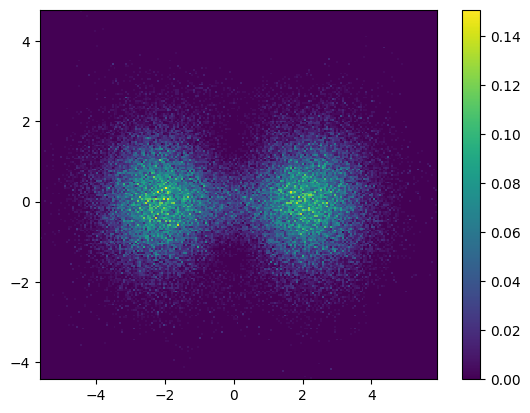

cuda:0
Acceptance Rate of MH:  0.3835
Epoch 0: loss = 5.7231
Epoch 20: loss = 3.8128
Epoch 40: loss = 3.6761
Epoch 60: loss = 3.6726
Epoch 80: loss = 3.4975
Epoch 100: loss = 3.5168
Epoch 120: loss = 3.6496
Epoch 140: loss = 3.5531
Epoch 160: loss = 3.5445
Epoch 180: loss = 3.5202
Epoch 200: loss = 3.5951
Epoch 220: loss = 3.6165
Epoch 240: loss = 3.6694
Epoch 260: loss = 3.5628
Epoch 280: loss = 3.5408
Epoch 300: loss = 3.5453
Epoch 320: loss = 3.4925
Epoch 340: loss = 3.5723
Epoch 360: loss = 3.5551
Epoch 380: loss = 3.4360


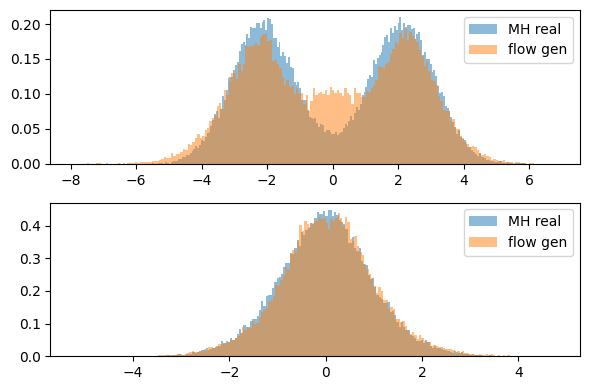

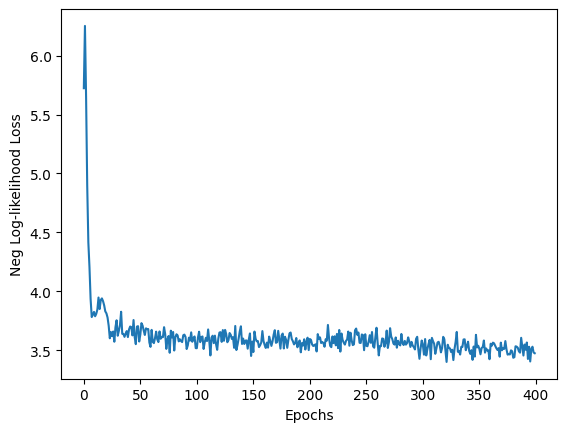

cuda:0
Epoch 0: loss=0.000176, frac_out=0.008
ESS_frac: 0.9055, KL-Divergnece 0.061080
Epoch 150: loss=0.000175, frac_out=0.005
ESS_frac: 0.9283, KL-Divergnece 0.043978
Epoch 300: loss=0.000175, frac_out=0.005
ESS_frac: 0.9346, KL-Divergnece 0.041914
Epoch 450: loss=0.000174, frac_out=0.004
ESS_frac: 0.9411, KL-Divergnece 0.036491
Epoch 600: loss=0.000175, frac_out=0.003
ESS_frac: 0.9448, KL-Divergnece 0.034178
Epoch 750: loss=0.000174, frac_out=0.004
ESS_frac: 0.9504, KL-Divergnece 0.031754
Epoch 900: loss=0.000174, frac_out=0.003
ESS_frac: 0.9544, KL-Divergnece 0.029495
Epoch 1050: loss=0.000174, frac_out=0.003
ESS_frac: 0.9560, KL-Divergnece 0.025308
Epoch 1200: loss=0.000174, frac_out=0.002
ESS_frac: 0.9615, KL-Divergnece 0.022816
Epoch 1350: loss=0.000174, frac_out=0.001
ESS_frac: 0.9648, KL-Divergnece 0.020541
Epoch 1500: loss=0.000173, frac_out=0.002
ESS_frac: 0.9699, KL-Divergnece 0.016046
Epoch 1650: loss=0.000173, frac_out=0.001
ESS_frac: 0.9741, KL-Divergnece 0.013408
Epoch 

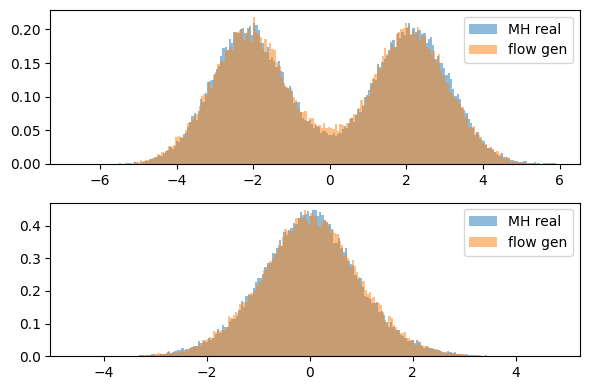

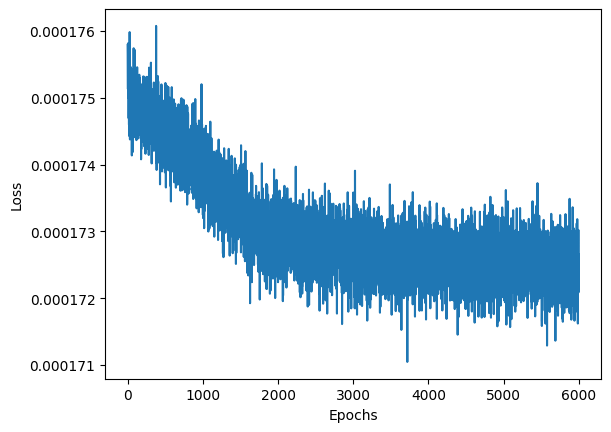

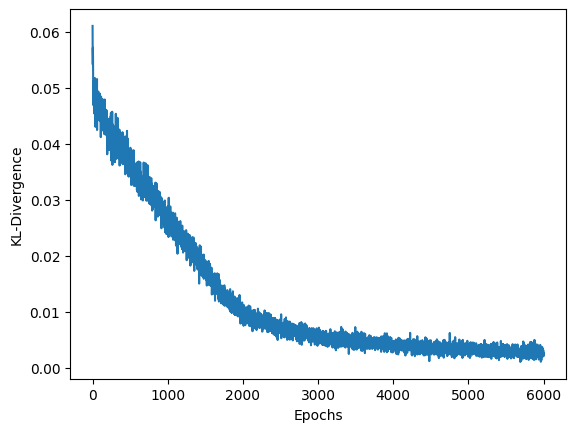

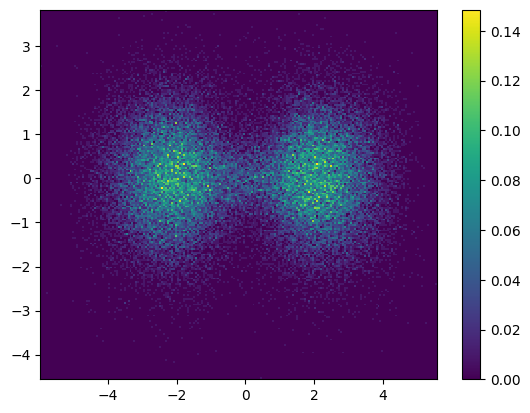

In [45]:
# initialise
Q_init = qt.qfunc(rho_cat, xvec, yvec)
# -----------------------------------------------------------------------------------------------
# checking normalization
# -----------------------------------------------------------------------------------------------
dx = xvec[1] - xvec[0]
dy = yvec[1] - yvec[0]
approx_norm = Q_init.sum() * dx * dy
print("Normalization: ", approx_norm)

# -----------------------------------------------------------------------------------------------
# step 1: get Q(theta) with M-H sampling from Q_init minimizing neg-log likelihood
# -----------------------------------------------------------------------------------------------
Q_init_samples = metropolis_hasting(N=100_000, sigma=0.5, b=7)
plt.hist2d(Q_init_samples[:,0], Q_init_samples[:,1], bins=200, density=True)
plt.colorbar()
plt.show()

loss1 = []

Flow_current, loss1 = train_init_flow(sample=Q_init_samples, epochs=400, lr=1e-3)

gen, _ = sample_from_flow(Flow_current, 50000)
gen = gen.detach().cpu().numpy()
real = np.asarray(Q_init_samples)

D = real.shape[1]
fig, axes = plt.subplots(min(D,4), 1, figsize=(6, 2*min(D,4)), squeeze=False)
for i in range(min(D,4)):
    ax = axes[i,0]
    ax.hist(real[:,i], bins=200, density=True, alpha=0.5, label='MH real')
    ax.hist(gen[:,i], bins=200, density=True, alpha=0.5, label='flow gen')
    ax.legend()
plt.tight_layout()
plt.show()

plt.plot(np.arange(0,len(loss1),1),loss1)
plt.xlabel('Epochs')
plt.ylabel('Neg Log-likelihood Loss')
plt.show()

# -----------------------------------------------------------------------------------------------
# step 2: minimize KL(Q_init || Q(theta))
# -----------------------------------------------------------------------------------------------

# now train the first Flow_current model {Q(theta)} to approximate Q_init
loss2 = []
kld = []

Flow_current, loss2, kld = refining_init_flow(flow=Flow_current, epochs=6000, lr=1e-4)

gen, _ = sample_from_flow(Flow_current, 50000)
gen = gen.detach().cpu().numpy()
real = np.asarray(Q_init_samples)

D = real.shape[1]
fig, axes = plt.subplots(min(D,4), 1, figsize=(6, 2*min(D,4)), squeeze=False)
for i in range(min(D,4)):
    ax = axes[i,0]
    ax.hist(real[:,i], bins=200, density=True, alpha=0.5, label='MH real')
    ax.hist(gen[:,i], bins=200, density=True, alpha=0.5, label='flow gen')
    ax.legend()
plt.tight_layout()
plt.show()


plt.plot(np.arange(0,len(loss2),1),loss2)
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.show()

plt.plot(np.arange(0,len(kld),1),kld)
plt.xlabel('Epochs')
plt.ylabel('KL-Divergence')
plt.show()

mask = (
    (gen[:, 0] >= xvec.min()) & (gen[:, 0] <= xvec.max()) &
    (gen[:, 1] >= yvec.min()) & (gen[:, 1] <= yvec.max())
)
gen_in = gen[mask]

plt.hist2d(gen_in[:,0], gen_in[:,1], bins=200, density=True)
plt.colorbar()
plt.show()

Mean absolute difference: 3.9685158680070796e-05
Total absolute difference: 1.587406347202832


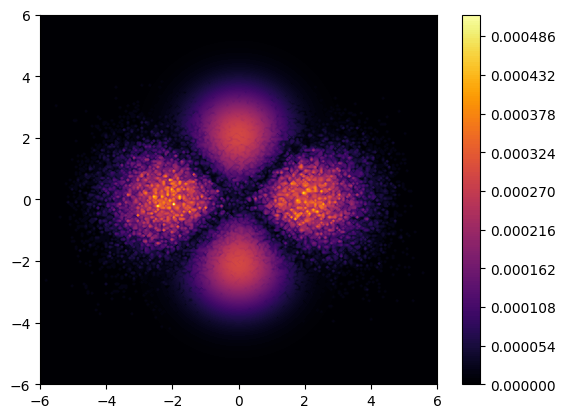

In [46]:
# Define same grid edges as the ground-truth Q function
x_edges = np.linspace(xvec.min(), xvec.max(), len(xvec)+1)
y_edges = np.linspace(yvec.min(), yvec.max(), len(yvec)+1)

# 2D histogram (normalized to integrate to 1)
H_gen, _, _ = np.histogram2d(gen[:, 0], gen[:, 1],
                             bins=[x_edges, y_edges],
                             density=True)

mask = (
    (gen[:, 0] >= xvec.min()) & (gen[:, 0] <= xvec.max()) &
    (gen[:, 1] >= yvec.min()) & (gen[:, 1] <= yvec.max())
)
gen_in = gen[mask]

# Ensure both have same shape
Q_norm = Q_init / np.sum(Q_init)
H_norm = H_gen / np.sum(H_gen)

abs_diff = np.abs(Q_norm - H_norm)
mean_abs_diff = np.mean(abs_diff)
total_abs_error = np.sum(abs_diff)

print("Mean absolute difference:", mean_abs_diff)
print("Total absolute difference:", total_abs_error)

# Visualize the difference
plt.contourf(xvec, yvec, abs_diff.T, 200, cmap='inferno')
plt.colorbar()
plt.show()



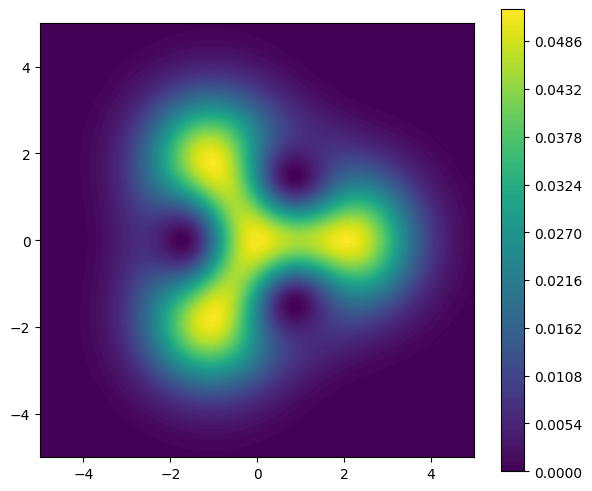

In [ ]:
import numpy as np
import qutip as qt
import matplotlib.pyplot as plt

def create_tri_cat_state(alpha, N):

    alpha_0 = alpha
    alpha_1 = alpha * np.exp(1j * 2 * np.pi / 3)
    alpha_2 = alpha * np.exp(1j * 4 * np.pi / 3)
    
    psi_0 = qt.coherent(N, alpha_0)
    psi_1 = qt.coherent(N, alpha_1)
    psi_2 = qt.coherent(N, alpha_2)
    
    psi = (psi_0 + psi_1 + psi_2).unit()
    
    return qt.ket2dm(psi)

def plot_q_function(rho, xvec, yvec):

    Q = qt.qfunc(rho, xvec, yvec)
    
    plt.figure(figsize=(7, 6))
    plt.contourf(xvec, yvec, Q, 100, cmap="viridis")
    plt.colorbar()
    plt.gca().set_aspect('equal', adjustable='box')

N = 30  

alpha = 1.5 


vec_range = 5  
xvec = np.linspace(-vec_range, vec_range, 200)
yvec = np.linspace(-vec_range, vec_range, 200)

rho_tri_cat = create_tri_cat_state(alpha=alpha, N=N)

plot_q_function(rho_tri_cat, xvec, yvec)
plt.show()

Normalization:  0.9988622662759009
Acceptance Rate of MH:  0.7449


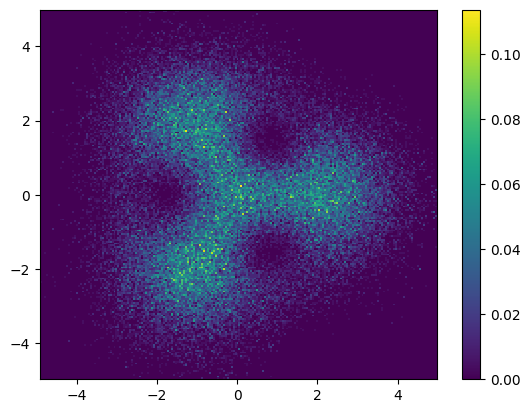

cuda:0
Acceptance Rate of MH:  0.3924
Epoch 0: loss = 5.5457
Epoch 20: loss = 4.0396
Epoch 40: loss = 3.9271
Epoch 60: loss = 3.8600
Epoch 80: loss = 3.8205
Epoch 100: loss = 3.8078
Epoch 120: loss = 3.7654
Epoch 140: loss = 3.7710
Epoch 160: loss = 3.8104
Epoch 180: loss = 3.7404


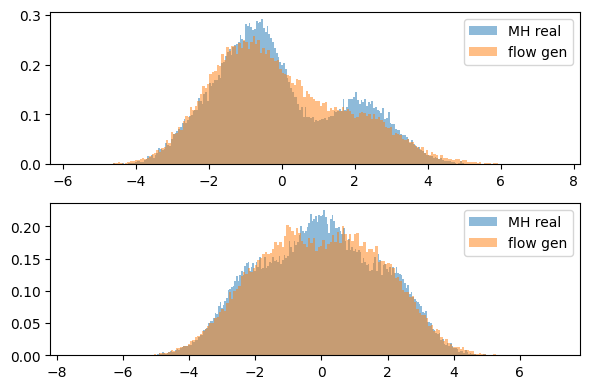

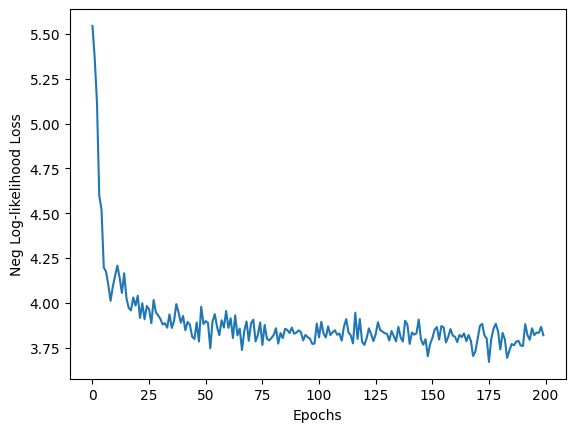

cuda:0
Epoch 0: loss=0.000190, frac_out=0.005
ESS_frac: 0.9127, KL-Divergnece 0.055451
Epoch 150: loss=0.000189, frac_out=0.002
ESS_frac: 0.9470, KL-Divergnece 0.031032
Epoch 300: loss=0.000188, frac_out=0.002
ESS_frac: 0.9765, KL-Divergnece 0.015769
Epoch 450: loss=0.000188, frac_out=0.001
ESS_frac: 0.9778, KL-Divergnece 0.011675
Epoch 600: loss=0.000188, frac_out=0.002
ESS_frac: 0.9816, KL-Divergnece 0.011240
Epoch 750: loss=0.000188, frac_out=0.002
ESS_frac: 0.9824, KL-Divergnece 0.010121
Epoch 900: loss=0.000188, frac_out=0.002
ESS_frac: 0.9846, KL-Divergnece 0.008820
Epoch 1050: loss=0.000188, frac_out=0.001
ESS_frac: 0.9872, KL-Divergnece 0.008151
Epoch 1200: loss=0.000188, frac_out=0.002
ESS_frac: 0.9851, KL-Divergnece 0.007737
Epoch 1350: loss=0.000188, frac_out=0.001
ESS_frac: 0.9872, KL-Divergnece 0.006848
Epoch 1500: loss=0.000188, frac_out=0.001
ESS_frac: 0.9868, KL-Divergnece 0.009056
Epoch 1650: loss=0.000188, frac_out=0.001
ESS_frac: 0.9851, KL-Divergnece 0.007043
Epoch 

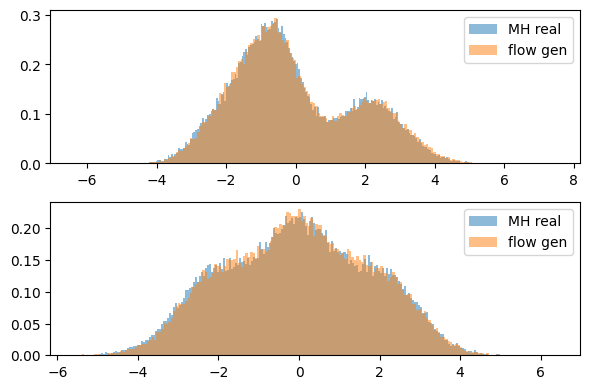

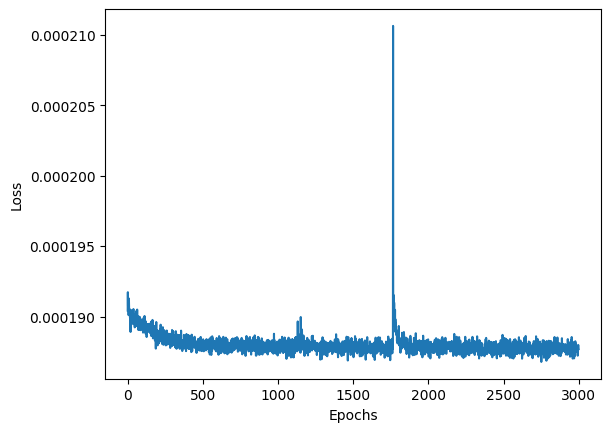

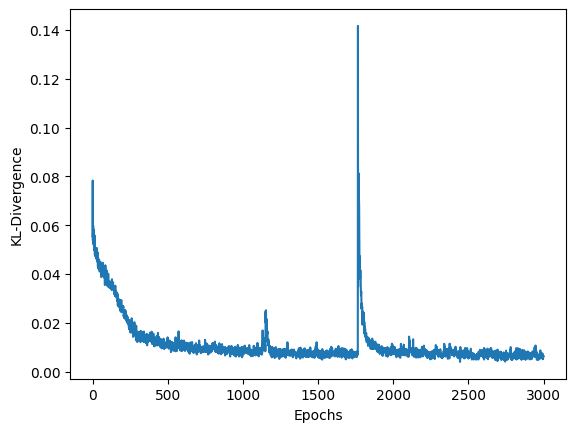

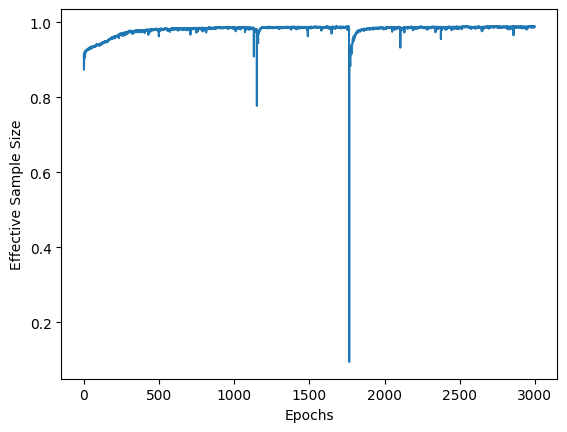

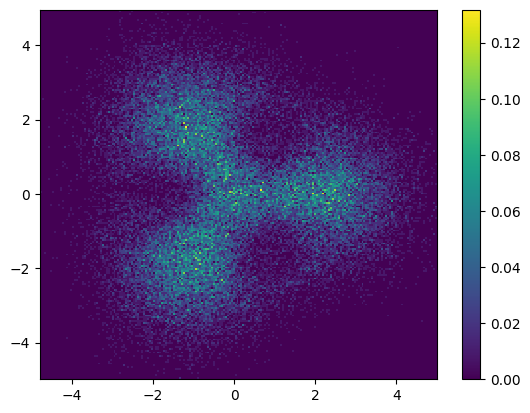

In [41]:
# initialise
Q_init = qt.qfunc(rho_tri_cat, xvec, yvec)
# -----------------------------------------------------------------------------------------------
# checking normalization
# -----------------------------------------------------------------------------------------------
dx = xvec[1] - xvec[0]
dy = yvec[1] - yvec[0]
approx_norm = Q_init.sum() * dx * dy
print("Normalization: ", approx_norm)

# -----------------------------------------------------------------------------------------------
# step 1: get Q(theta) with M-H sampling from Q_init minimizing neg-log likelihood
# -----------------------------------------------------------------------------------------------
Q_init_samples = metropolis_hasting(N=100_000, sigma=0.5, b=7)
plt.hist2d(Q_init_samples[:,0], Q_init_samples[:,1], bins=200, density=True)
plt.colorbar()
plt.show()

loss1 = []

Flow_current, loss1 = train_init_flow(sample=Q_init_samples, epochs=200, lr=1e-3)

gen, _ = sample_from_flow(Flow_current, 50000)
gen = gen.detach().cpu().numpy()
real = np.asarray(Q_init_samples)

D = real.shape[1]
fig, axes = plt.subplots(min(D,4), 1, figsize=(6, 2*min(D,4)), squeeze=False)
for i in range(min(D,4)):
    ax = axes[i,0]
    ax.hist(real[:,i], bins=200, density=True, alpha=0.5, label='MH real')
    ax.hist(gen[:,i], bins=200, density=True, alpha=0.5, label='flow gen')
    ax.legend()
plt.tight_layout()
plt.show()

plt.plot(np.arange(0,len(loss1),1),loss1)
plt.xlabel('Epochs')
plt.ylabel('Neg Log-likelihood Loss')
plt.show()

# -----------------------------------------------------------------------------------------------
# step 2: minimize KL(Q_init || Q(theta))
# -----------------------------------------------------------------------------------------------

# now train the first Flow_current model {Q(theta)} to approximate Q_init
loss2 = []
kld = []

Flow_current, loss2, kld, ess = refining_init_flow(flow=Flow_current, epochs=3000, lr=1e-3)

gen, _ = sample_from_flow(Flow_current, 50000)
gen = gen.detach().cpu().numpy()
real = np.asarray(Q_init_samples)

D = real.shape[1]
fig, axes = plt.subplots(min(D,4), 1, figsize=(6, 2*min(D,4)), squeeze=False)
for i in range(min(D,4)):
    ax = axes[i,0]
    ax.hist(real[:,i], bins=200, density=True, alpha=0.5, label='MH real')
    ax.hist(gen[:,i], bins=200, density=True, alpha=0.5, label='flow gen')
    ax.legend()
plt.tight_layout()
plt.show()


plt.plot(np.arange(0,len(loss2),1),loss2)
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.show()

plt.plot(np.arange(0,len(kld),1),kld)
plt.xlabel('Epochs')
plt.ylabel('KL-Divergence')
plt.show()

plt.plot(np.arange(0,len(ess),1),ess)
plt.xlabel('Epochs')
plt.ylabel('Effective Sample Size')
plt.show()

mask = (
    (gen[:, 0] >= xvec.min()) & (gen[:, 0] <= xvec.max()) &
    (gen[:, 1] >= yvec.min()) & (gen[:, 1] <= yvec.max())
)
gen_in = gen[mask]

plt.hist2d(gen_in[:,0], gen_in[:,1], bins=200, density=True)
plt.colorbar()
plt.show()

Mean absolute difference: 2.169302114012767e-05
Total absolute difference: 0.8677208456051068


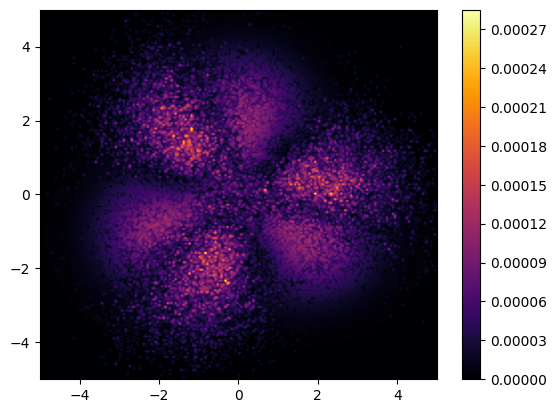

In [ ]:
# define same grid edges as the ground-truth Q function
x_edges = np.linspace(xvec.min(), xvec.max(), len(xvec)+1)
y_edges = np.linspace(yvec.min(), yvec.max(), len(yvec)+1)

# 2D histogram (normalized to integrate to 1)
H_gen, _, _ = np.histogram2d(gen[:, 0], gen[:, 1],
                             bins=[x_edges, y_edges],
                             density=True)

mask = (
    (gen[:, 0] >= xvec.min()) & (gen[:, 0] <= xvec.max()) &
    (gen[:, 1] >= yvec.min()) & (gen[:, 1] <= yvec.max())
)
gen_in = gen[mask]

# ensure both have same shape
Q_norm = Q_init / np.sum(Q_init)
H_norm = H_gen / np.sum(H_gen)

abs_diff = np.abs(Q_norm - H_norm)
mean_abs_diff = np.mean(abs_diff)
total_abs_error = np.sum(abs_diff)

print("Mean absolute difference:", mean_abs_diff)
print("Total absolute difference:", total_abs_error)

# visualize the difference
plt.contourf(xvec, yvec, abs_diff.T, 200, cmap='inferno')
plt.colorbar()
plt.show()



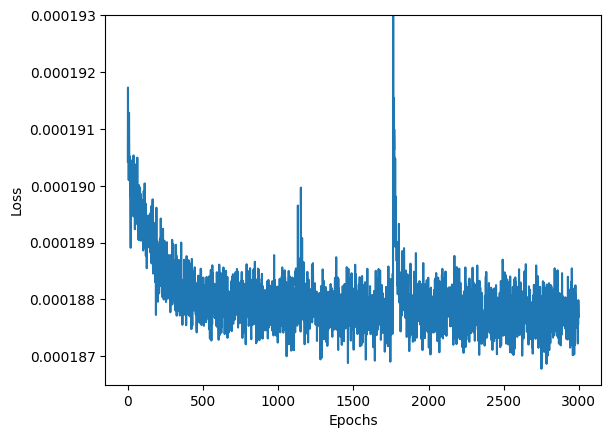

3.8191139698028564
0.00018769635062199086


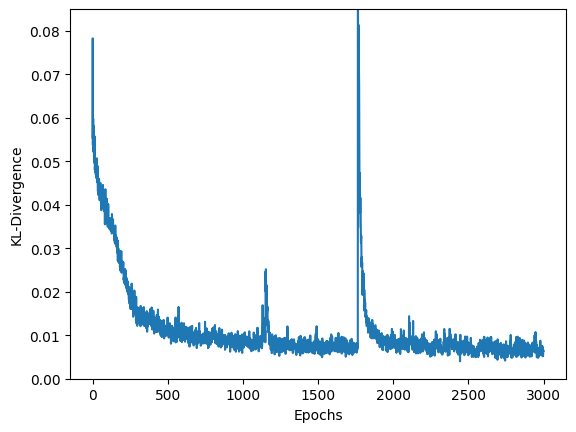

0.006411595270037651


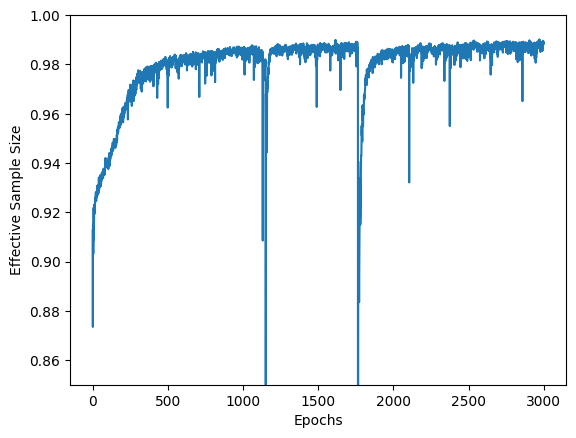

0.9882752


In [51]:
plt.plot(np.arange(0,len(loss2),1),loss2)
plt.ylim(0.0001865,0.000193)
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.show()

print(loss1[-1])
print(loss2[-1])

plt.plot(np.arange(0,len(kld),1),kld)
plt.ylim(0,0.085)
plt.xlabel('Epochs')
plt.ylabel('KL-Divergence')
plt.show()

print(kld[-1])

plt.plot(np.arange(0,len(ess),1),ess)
plt.ylim(0.85,1)
plt.xlabel('Epochs')
plt.ylabel('Effective Sample Size')
plt.show()

print(ess[-1])